In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle
from math import isnan
from scipy.optimize import minimize
import spin_package.spherical_fixed_T as spherical_T
import spin_package.utils as sp_utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## State Following Fixed Temperatures

In [152]:
p = 1000
n_points_m = 100
n_points_less_T = 1
n_points_T = 1
n_points_more_T = 10

T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="spherical")

Teqs = np.hstack(
    (
        (T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_less_T + 1))[::-1],
        np.linspace(T_kauz, T_dyn, n_points_T + 1),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
T_planting = T_kauz
J0 = 0.5 / T_planting

m2i = 0.99
q2i = 0.99

In [168]:
ms = np.linspace(0.995, 0.9999, n_points_m)
q_old = 0.9999
all_data = {}

for jdx, T in enumerate(tqdm(Teqs, desc="RS")):
    data = sp_utils.observables(["q", "m", "f"], (n_points_m,))
    total_file_name = "../data/spherical/" + sp_utils.get_file_name_T_sweep_m(
        "spherical", p, T_planting, T, ms
    )
    if False:#os.path.exists(total_file_name):
        with open(total_file_name, "rb") as f:
            data = pickle.load(f)
    else:
        for idx, m in enumerate(tqdm(ms, desc="m", leave=False)):
            q = spherical_T.fixed_points_q_J0(m, 1/T, p, blend=0.99, q_init=q_old)
            data["q"][idx] = q
            data["m"][idx] = m
            data["f"][idx] = spherical_T.f_FP_J0(q, m, p, 1/T, J0)

            q_old = q

        with open(total_file_name, "wb") as f:
            pickle.dump(data, f)

    all_data[T] = data

print("Data is saved.")

RS:   0%|          | 0/13 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

q_new = 1.0000014726289135
q_new = 1.0000034187026128
q_new = 1.0000054007889387
q_new = 1.0000074189710273
q_new = 1.0000094729578168
q_new = 1.000011569932767
q_new = 1.0000137107386253
q_new = 1.0000158955687068
q_new = 1.000018133372937
q_new = 1.000020422931658
q_new = 1.0000227717421606
q_new = 1.00002518694226
q_new = 1.0000276703893614
q_new = 1.0000302315776173
q_new = 1.0000328811690848
q_new = 1.0000356247883615
q_new = 1.0000017805605077
q_new = 1.0000384771848552
q_new = 1.0000060255309877
q_new = 1.000041451309678
q_new = 1.000010467152684
q_new = 1.0000445707419272
q_new = 1.0000151388797358
q_new = 1.0000478559236754
q_new = 1.0000200771939087
q_new = 1.000000678504224
q_new = 1.0000513415400434
q_new = 1.0000253354811928
q_new = 1.0000067424096644
q_new = 1.0000550723569201
q_new = 1.0000309851127651
q_new = 1.0000133361802392
q_new = 1.000000267959205
q_new = 1.0000591092271152
q_new = 1.0000371260716974
q_new = 1.000020598759232
q_new = 1.0000080414426649
q_new = 1.0

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

Data is saved.


In [169]:
m0, q0 = 1 - 1 / p**2, 1 - 1 / p**2
blend = 0.9
total_file_name = "../data/spherical/" + sp_utils.get_file_name_sweep_T(
    "spherical", p, T_planting, Teqs, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(Teqs),))
    for i, T in enumerate(tqdm(Teqs)):
        m, q = m0, q0
        err = 1
        while err > 1e-7:
            m_new = spherical_T.newm(m, q, p, 1/T)
            q_new = spherical_T.newq(m, q, p, 1/T, J0)
            
            if isnan(m_new) or isnan(q_new):
                break
            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        data_fixed_point["T"][i] = T
        data_fixed_point["m"][i] = m_new
        data_fixed_point["q"][i] = q_new
        data_fixed_point["f"][i] = spherical_T.f_FP_J0(q, m, p, 1/T, J0)
        data_fixed_point["e"][i] = spherical_T.e_J0(q, m, p, 1/T, J0)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is already saved.
Data is loaded.


In [170]:
data_fixed_point["m"]

array([0.99992713, 0.99987488, 0.9998163 , 0.99974932, 0.99967051,
       0.99957348, 0.99944339, 0.99922128,        nan,        nan,
              nan,        nan,        nan])

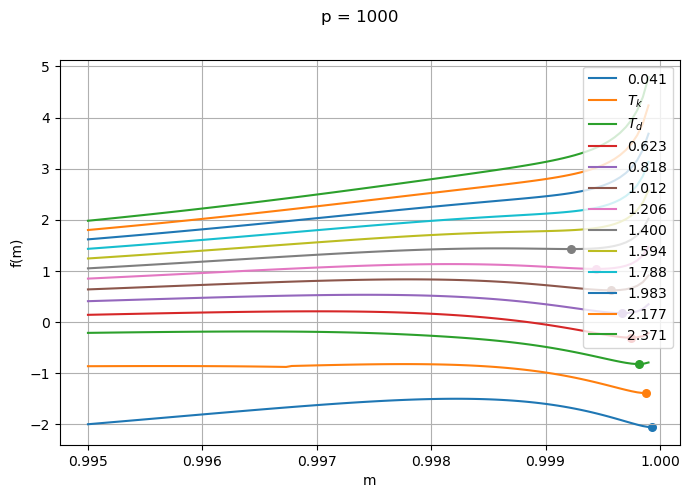

In [171]:
plt.figure(figsize=(8,5))
plt.suptitle(f"p = {p:d}")
for i, T in enumerate(Teqs):
    legend_name = sp_utils.legend_name_Tk_Td_T(T, T_kauz, T_dyn)

    data = all_data[T]
    plt.plot(data['m'], data['f'], label=legend_name, color=f'C{i}')

    plt.scatter(data_fixed_point['m'][i], data_fixed_point['f'][i], color=f'C{i}', marker='o', s=30)

plt.xlabel('m')
plt.ylabel(r'f(m)')
plt.legend()
plt.grid()


## State Following Untill Losing

In [62]:
p = 10
T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="spherical")
T_planting = T_kauz
J0 = 0.5 / T_planting

T_start = T_kauz
deltaT = 1e-5
m0, q0 = 1 - 1 / p**2, 1 - 1 / p**2

In [63]:
blend = 0.5
total_file_name = "../data/spherical/" + sp_utils.get_file_name_until_fail(
    "spherical", p, T_planting, T_start, deltaT, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_T, tmp_m, tmp_q, tmp_f, tmp_e = [], [], [], [], []
    cur_T = T_start
    m, q = m0, q0
    while True:
        print(f"T = {cur_T:.3f}, m = {m:.3f}, q = {q:.3f}")
        err = 1
        while err > 1e-7:
            m_new = spherical_T.newm(m, q, p, 1/cur_T)
            q_new = spherical_T.newq(m, q, p, 1/cur_T, J0)

            if isnan(m_new) or isnan(q_new):
                break

            # check if m_new or q_new is none
            # if m_new is None or q_new is None or q < 0 or m < 0 or q_new < 0 or m_new < 0:
            #     print(f"m : {m:.3f}, q : {q:.3f}")
            #     print(f"m_new : {m_new}, q_new : {q_new}")

            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        print(f"T = {cur_T:.3f}, m = {m:.3f}, q = {q:.3f}")
        if abs(m) < 1e-7:
            break
        elif isnan(m) or isnan(q) or q < 0 or m < 0:
            break
        else:
            tmp_T.append(cur_T)
            tmp_m.append(m)
            tmp_q.append(q)
            tmp_f.append(spherical_T.f_FP_J0(q, m, p, 1/cur_T, J0))
            tmp_e.append(spherical_T.e_J0(q, m, p, 1/cur_T, J0))

            cur_T += deltaT

    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(tmp_T),))
    data_fixed_point["T"] = np.array(tmp_T)
    data_fixed_point["m"] = np.array(tmp_m)
    data_fixed_point["q"] = np.array(tmp_q)
    data_fixed_point["f"] = np.array(tmp_f)
    data_fixed_point["e"] = np.array(tmp_e)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is not saved.
T = 0.280, m = 1.000, q = 1.000
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998,

Text(0.5, 1.0, 'p = 100')

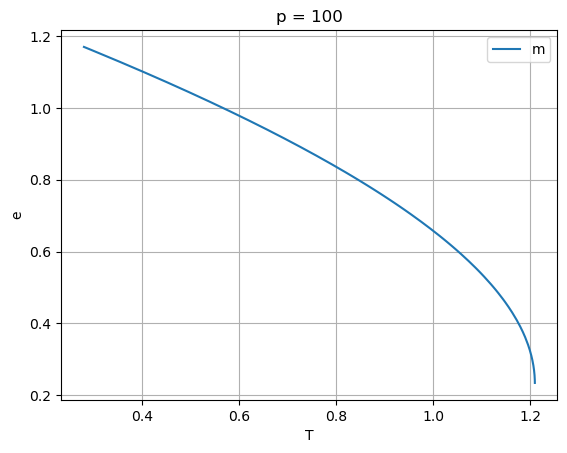

In [64]:
plt.plot(data_fixed_point['T'], data_fixed_point['e'], label='m')
plt.grid()
plt.xlabel('T')
plt.ylabel('e')
plt.legend()
plt.title(f"p = {p:d}")

## $T_d^+(p)$ from State Following

In [110]:
p_tab = np.unique(np.logspace(np.log10(3), np.log10(8_000), 50, dtype=int))
deltaT = 1e-5
blend = 0.5
total_file_name = "../data/spherical/" + sp_utils.get_file_name_Tdplus_Tk(
        "spherical", deltaT, m0, q0, p_tab[0], p_tab[-1], len(p_tab)
    )
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_Td_plus = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_T_tab, tmp_m_tab, tmp_q_tab, tmp_f_tab, tmp_e_tab = [], [], [], [], []
    for p in tqdm(p_tab):
        m0, q0 = 1 - 1 / p**2, 1 - 1 / p**2
        T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="spherical")
        T_planting = T_kauz
        J0 = 0.5 / T_planting
        T_start = T_kauz

        cur_T = T_start
        m, q = m0, q0
        while True:
            # print(f"T = {cur_T:.3f}")
            err = 1
            while err > 1e-7:
                m_new = spherical_T.newm(m, q, p, 1/cur_T)
                q_new = spherical_T.newq(m, q, p, 1/cur_T, J0)
                
                if isnan(m_new) or isnan(q_new):
                    break

                err = max(abs(q_new - q), abs(m_new - m))
                m = blend * m + (1 - blend) * m_new
                q = blend * q + (1 - blend) * q_new

            if abs(m) < 1e-7:
                break
            elif isnan(m) or isnan(q) or q < 0 or m < 0:
                break
            else:
                tmp_m = m
                tmp_q = q
                tmp_T = cur_T
                tmp_e = spherical_T.e_J0(q, m, p, 1/cur_T, J0)
                tmp_f = spherical_T.f_FP_J0(q, m, p, 1/cur_T, J0)
                cur_T += deltaT
        tmp_T_tab.append(tmp_T)
        tmp_m_tab.append(tmp_m)
        tmp_q_tab.append(tmp_q)
        tmp_f_tab.append(tmp_f)
        tmp_e_tab.append(tmp_e)
    data_Td_plus = sp_utils.observables(["p","T", "q", "m", "f", "e"], (len(tmp_T_tab),))
    data_Td_plus["p"] = np.array(p_tab)
    data_Td_plus["T"] = np.array(tmp_T_tab)
    data_Td_plus["m"] = np.array(tmp_m_tab)
    data_Td_plus["q"] = np.array(tmp_q_tab)
    data_Td_plus["f"] = np.array(tmp_f_tab)
    data_Td_plus["e"] = np.array(tmp_e_tab)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_Td_plus, f)

    print("Data is saved.")

Data is not saved.


  0%|          | 0/48 [00:00<?, ?it/s]

Data is saved.


In [111]:
Tds = np.empty(len(p_tab))
Tks = np.empty(len(p_tab))

for i, p in enumerate(p_tab):
    Tks[i], Tds[i] = sp_utils.get_Tk_Td(p, model="spherical")

In [112]:
tdplus = data_Td_plus["T"]
last_points = 10
poly_coeff = np.polyfit(
    np.sqrt(np.log(p_tab[-last_points:])), tdplus[-last_points:], 1
)
print(f"poly_coeff = {poly_coeff}")
poly_fitted = np.poly1d(poly_coeff)

poly_coeff = [0.54366737 0.0432679 ]


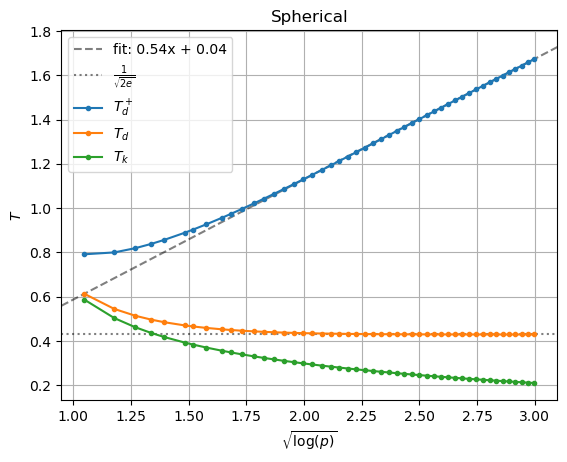

In [113]:
xs = np.linspace(
    np.min(np.sqrt(np.log(p_tab))) - 0.1, np.max(np.sqrt(np.log(p_tab))) + 0.1, 100
)

plt.plot(
    xs,
    poly_fitted(xs),
    "k--",
    label=f"fit: {poly_coeff[0]:.2f}x + {poly_coeff[1]:.2f}",
    alpha=0.5,
)
plt.plot(xs, np.ones_like(xs)/ np.sqrt(2 * np.exp(1)), 'k:', label=r'$\frac{1}{\sqrt{2e}}$', alpha=0.5)

plt.plot(np.sqrt(np.log(data_Td_plus['p'])), data_Td_plus['T'], label=r'$T_d^+$', marker='.')
plt.plot(np.sqrt(np.log(p_tab)), Tds, label=r'$T_d$', marker='.')
plt.plot(np.sqrt(np.log(p_tab)), Tks, label=r'$T_k$', marker='.')

plt.title('Spherical')
plt.xlabel('$\\sqrt{\\log(p)}$')
plt.ylabel(r'$T$')
plt.legend()
plt.xlim(np.min(xs), np.max(xs))
plt.grid()

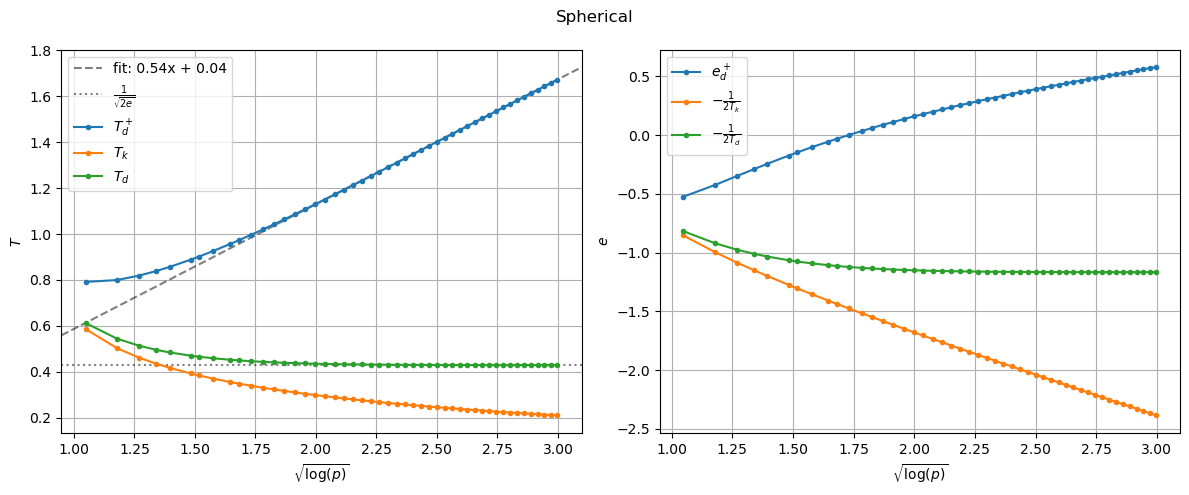

In [114]:
xs = np.linspace(
    np.min(np.sqrt(np.log(p_tab))) - 0.1, np.max(np.sqrt(np.log(p_tab))) + 0.1, 100
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(
    xs,
    poly_fitted(xs),
    "k--",
    label=f"fit: {poly_coeff[0]:.2f}x + {poly_coeff[1]:.2f}",
    alpha=0.5,
)
plt.plot(
    xs,
    np.ones_like(xs) / np.sqrt(2 * np.exp(1)),
    "k:",
    label=r"$\frac{1}{\sqrt{2e}}$",
    alpha=0.5,
)
plt.plot(
    np.sqrt(np.log(data_Td_plus["p"])), data_Td_plus["T"], label=r"$T_d^+$", marker="."
)
plt.plot(np.sqrt(np.log(p_tab)), Tks, label=r"$T_k$", marker=".")
plt.plot(np.sqrt(np.log(p_tab)), Tds, label=r"$T_d$", marker=".")

plt.xlabel("$\\sqrt{\\log(p)}$")
plt.ylabel(r"$T$")
plt.legend()
plt.xlim(np.min(xs), np.max(xs))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(
    np.sqrt(np.log(data_Td_plus["p"])), data_Td_plus["e"], label=r"$e_d^+$", marker="."
)
plt.plot(np.sqrt(np.log(p_tab)), -1/(2*Tks), label=r'$-\frac{1}{2T_k}$', marker='.')
plt.plot(np.sqrt(np.log(p_tab)), -1/(2*Tds), label=r'$-\frac{1}{2T_d}$', marker='.')

plt.xlabel("$\\sqrt{\\log(p)}$")
# plt.xlabel("$p$")
plt.ylabel(r"$e$")
plt.legend()
plt.grid()

plt.suptitle("Spherical")
plt.tight_layout()

#plt.savefig("../imgs/spherical_Tdplus_edplus.png", dpi=360)

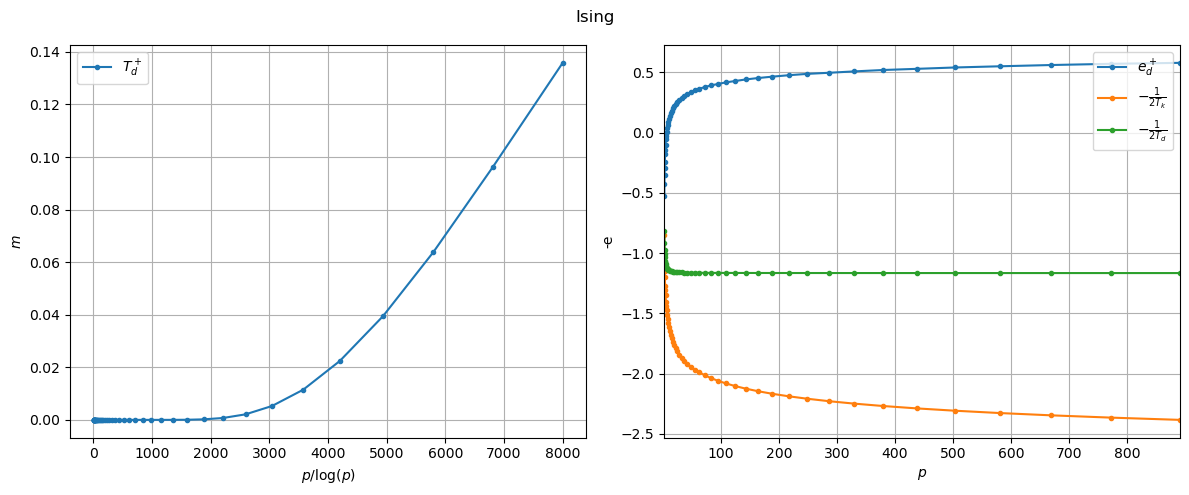

In [128]:
xs = np.linspace(np.min(p_tab / np.log(p_tab)) - 0.3, np.max(p_tab / np.log(p_tab)) + 0.3, 100)

plt.figure(figsize=(12, 5))
plt.suptitle("Ising")
plt.subplot(1, 2, 1)

plt.plot(
    
    data_Td_plus["p"][1:],
    data_Td_plus["q"][1:]**p,#**data_Td_plus["p"][1:],
    label=r"$T_d^+$",
    marker=".",
)
#plt.plot(p_tab / np.log(p_tab), Tks, label=r"$T_k$", marker=".")
#plt.plot(p_tab / np.log(p_tab), Tds, label=r"$T_d$", marker=".")

plt.xlabel("$p/ \\log(p)$")
plt.ylabel(r"$m$")
plt.legend()
#plt.xscale("log")
#plt.yscale("log")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_Td_plus["p"]/np.log(data_Td_plus["p"]), data_Td_plus["e"], ".-", label=r"$e_d^+$")
plt.plot(p_tab/np.log(p_tab), -1/(2*Tks), ".-", label=r"$-\frac{1}{2T_k}$")
plt.plot(p_tab/np.log(p_tab), -1/(2*Tds), ".-", label=r"$-\frac{1}{2T_d}$")
#plt.xscale("log")
#plt.yscale("log")

plt.xlabel("$p$")
plt.ylabel("-e")
plt.legend()
plt.xlim(np.min(xs), np.max(xs))

plt.grid()

plt.tight_layout()

#plt.savefig("../imgs/ising_Tdplus_edplus_lin.png", dpi=360)